In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from scipy import stats

In [2]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
data_df = pd.read_csv(path+'/clustered_df.csv', sep=',', header=0)
#data_df.reset_index(inplace=True)

In [3]:
data_df['date'] = pd.DatetimeIndex(data_df['date'])

In [4]:
data_df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'unique_id', 'Unnamed: 0', 'date',
       'time', 'date_time', 'agency', 'agency_name', 'inquiry_name',
       'brief_description', 'call_resolution', 'inquiry_with_description',
       'Inquiry_names', 'cluster_label', 'embed_0', 'embed_1',
       'Centroid_text'],
      dtype='object')

### Top 8 clusters according to count
5	Waterway Complaint	3357428
7	Living Wage Increase for Subsidized Projects	2359171
4	Reclaim a Towed Vehicle - NYPD	2320110
11	Smokeless Tobacco Law Information	1670471
3	Carpool or RideMatch	1645582
12	Find a Towed Vehicle - Blocking a Driveway	1243519
13	Pay a Parking Ticket - By Mail	1145085
0	Gas Service and Billing	1085403

In [111]:
all_clusters_data = data_df[data_df['cluster_label'].isin([5,7,4,11,3,12])]

In [27]:
_5_cluster_data = data_df[data_df['cluster_label']==5]
_7_cluster_data = data_df[data_df['cluster_label']==7]
_4_cluster_data = data_df[data_df['cluster_label']==4]
_11_cluster_data = data_df[data_df['cluster_label']==11]
_3_cluster_data = data_df[data_df['cluster_label']==3]
_12_cluster_data = data_df[data_df['cluster_label']==12]

In [112]:
daily_clusters_df = all_clusters_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")

In [28]:
daily_5_cluster_df = _5_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_7_cluster_df = _7_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_4_cluster_df = _4_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_11_cluster_df = _11_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_3_cluster_df = _3_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_12_cluster_df = _12_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")

In [104]:
daily_clusters_df

,date,inquiries_per_day
0,2017-01-01,5153
1,2017-01-02,7882
2,2017-01-03,15439
3,2017-01-04,14965
4,2017-01-05,15029
...,...,...
1083,2019-12-27,9434
1084,2019-12-28,5335
1085,2019-12-29,4725
1086,2019-12-30,10827


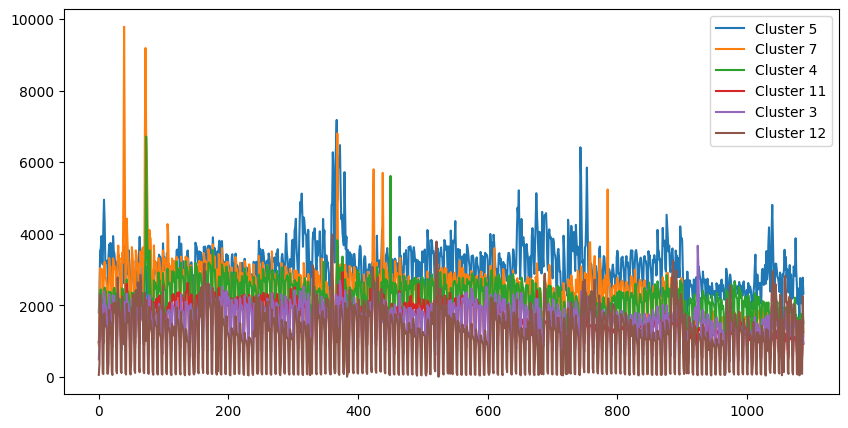

In [40]:
#plt.plot(daily_clusters_df['inquiries_per_day'], label='Data combined')
plt.plot(daily_5_cluster_df['inquiries_per_day'], label='Cluster 5')
plt.plot(daily_7_cluster_df['inquiries_per_day'], label='Cluster 7')
plt.plot(daily_4_cluster_df['inquiries_per_day'], label='Cluster 4')
plt.plot(daily_11_cluster_df['inquiries_per_day'], label='Cluster 11')
plt.plot(daily_3_cluster_df['inquiries_per_day'], label='Cluster 3')
plt.plot(daily_12_cluster_df['inquiries_per_day'], label='Cluster 12')
plt.legend();

## Feature Engineering

In [105]:
import holidays
nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019])

In [113]:
# function to create seasons for dataframe
def get_seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

# function to create holidays for dataframe
def get_holidays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''

    # Create a DataFrame of holidays
    holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holidays_df = holidays_df.set_index(['date'])
    
    # Join the holidays DataFrame with the original DataFrame
    df = df.join(holidays_df, on='date')
    df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)

    return df

# function to create weekdays for dataframe
def get_weekdays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''
    df['weekday'] = df.index.weekday
    ### one hot encode the feature weekday
    weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
    df = df.join(weekday_dummies, how='left')

    return df


Sunday - 6
Monday - 0
Tuesday - 1
Wednesday - 2
Thursday - 3
Friday - 4
Saturday - 5

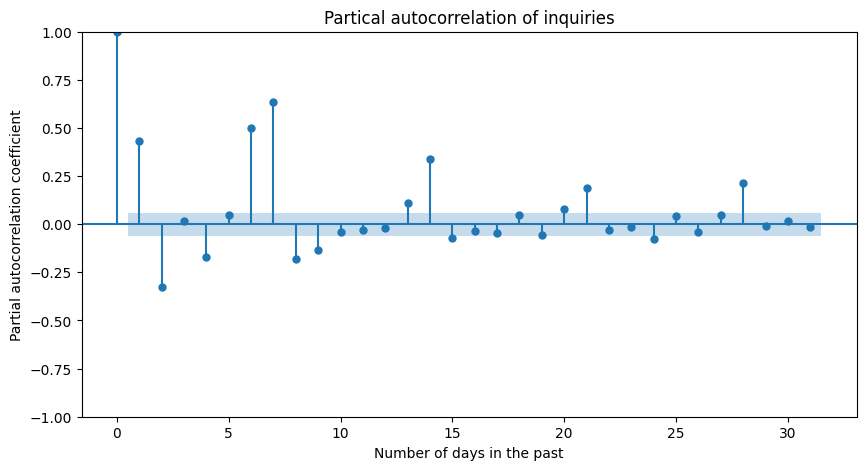

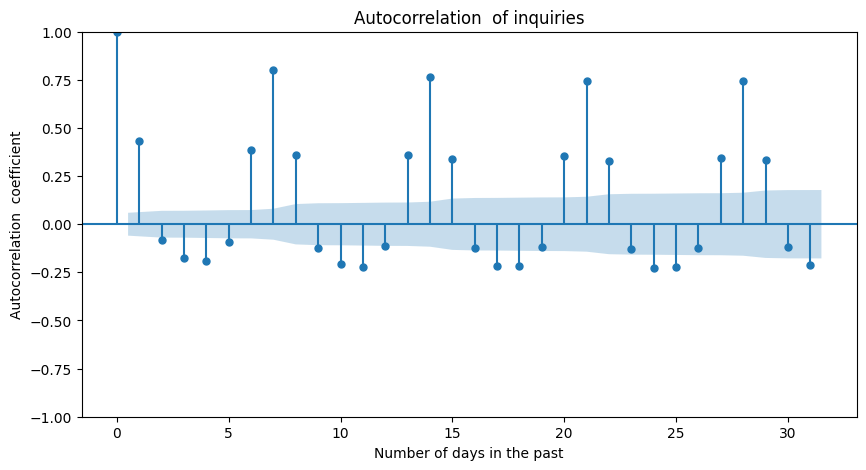

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [127]:
# function to create weekdays for dataframe
def get_features(df,lags):
    '''
    Function to create new features
    Args: df = dataframe
    Returns: df = dataframe
    '''
    df.reset_index(inplace = True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace = True)

    df = get_seasons(df).fillna(0)
    df = get_holidays(df)
    df = get_weekdays(df)
    df[f'Inq_mean_{lags}'] = df['inquiries_per_day'].rolling(window=lags).mean()

    return df



In [ ]:
daily_clusters_df = get_features(daily_clusters_df,7)

In [146]:
from scipy.stats import chi2_contingency, randint

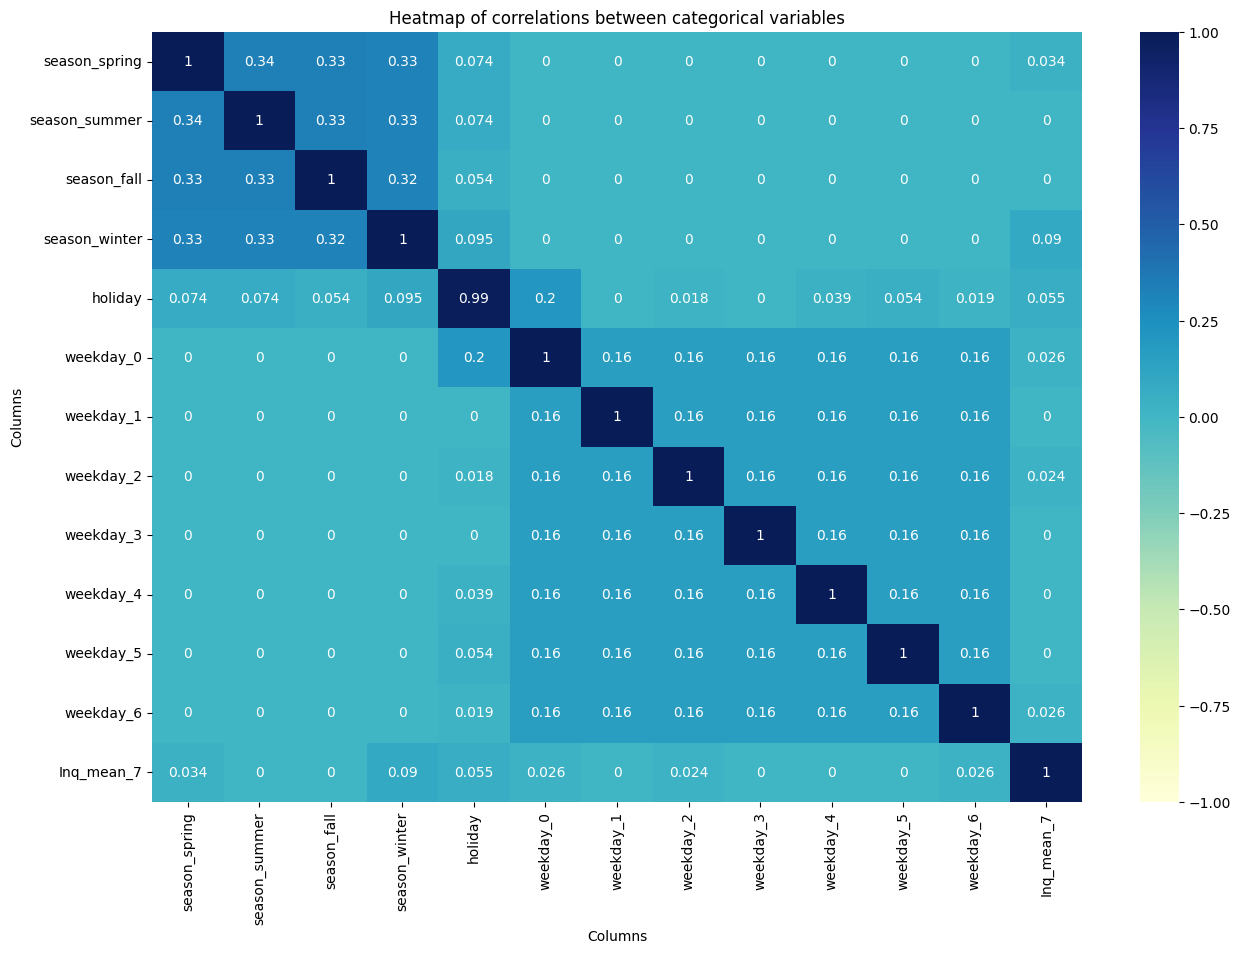

In [126]:
# drop any non-categorical variables
Daily_data_corr_cat = daily_clusters_df.drop(columns=['index','weekday', 'inquiries_per_day'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

## Modeling with Lazy Predict

In [128]:
final_df  = daily_clusters_df.drop(columns=['weekday', 'index']).fillna(0)
final_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [129]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:21<00:00,  1.92it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.90       0.90   1054.14   
RandomForestRegressor                        0.88       0.89   1153.71   
HistGradientBoostingRegressor                0.88       0.88   1156.80   
LGBMRegressor                                0.88       0.88   1162.71   
KNeighborsRegressor                          0.86       0.87   1227.16   
BaggingRegressor                             0.86       0.87   1242.00   
ExtraTreesRegressor                          0.85       0.86   1297.18   
PoissonRegressor                             0.84       0.85   1331.88   
XGBRegressor                                 0.84       0.85   1333.24   
RidgeCV                                      0.81       0.82   1428.50   
LinearRegression                             0.81       0.82   1429.18   
TransformedTargetRegressor            

### RandomForestRegressor

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [135]:
# Load dataset into a pandas dataframe
df = final_df
# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 11507790.396006558
Bias: -10176794.307754265


In [191]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

1172.7666357169462

### Hyperparameter Tuning with cross validation

In [148]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

Random search on combined dataset

In [150]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
random_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_dist = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 3),
              "bootstrap": [True]}

# Create the randomized search object
random_search = RandomizedSearchCV(random_search_model, param_distributions=param_dist, 
                                   n_iter=500, cv=tscv, 
                                   scoring="neg_mean_squared_error", 
                                   random_state=0)

# Fit the model to the data
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.15, shuffle = False, random_state = 0)


# Fit the randomized search on the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_random = random_search.best_params_
print(best_params_random)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


Grid search on combined dataset

In [156]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.15, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}


Modeling with best parameters

In [158]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_all = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_all.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
train_pred = best_rfr_all.predict(X_train)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_allTopClusters = best_rfr_all.predict(X_test)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, test_pred_allTopClusters)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_all = mean_squared_error(y_test, test_pred_allTopClusters)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_allTopClusters))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = test_pred_allTopClusters.var()
bias = mse_all - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Train MAE:  544.5008504194009
Train RMSE: 882.2230787209886
Test MAE:  1688.9349297372669
Test RMSE: 2138.5930446286566
Model: Random Forest Regressor
Variance: 10522033.235674568
Bias: -5948453.0251405


Data is still overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [167]:
train_rf = pd.DataFrame()
train_rf['train'] = y_train
train_rf['train_pred'] = train_pred
predictions_rf = pd.DataFrame()
predictions_rf['test'] = y_test
predictions_rf['test_pred'] = test_pred_allTopClusters
train_rf['residuals'] = train_rf['train'] - train_rf['train_pred']
predictions_rf['residuals'] = predictions_rf['test'] - predictions_rf['test_pred']

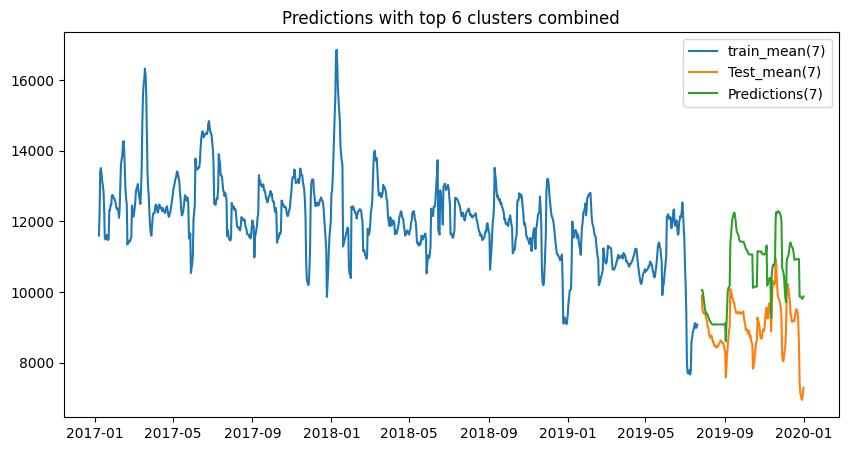

In [174]:
plt.title('Predictions with top 6 clusters combined')
plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='train_mean(7)')
plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Test_mean(7)','Predictions(7)'])
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [186]:
new_plot=train_rf[train_rf.index.year == 2019]

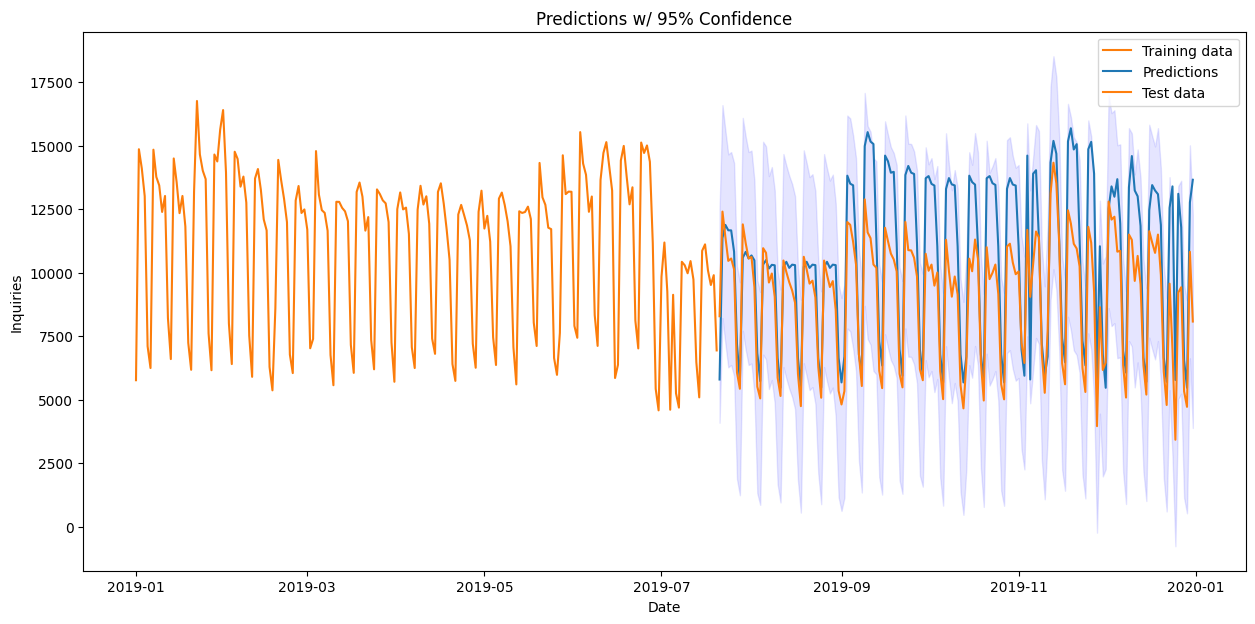

In [190]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf['residuals'] ]) / len(predictions_rf['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['train'], color='#fc7d0b', label='Training data')
ax.plot(predictions_rf.index, predictions_rf['test_pred'], label='Predictions')
ax.plot(predictions_rf.index, predictions_rf['test'], label='Test data')
ax.fill_between(predictions_rf.index, (predictions_rf['test']-band_size), (predictions_rf['test']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

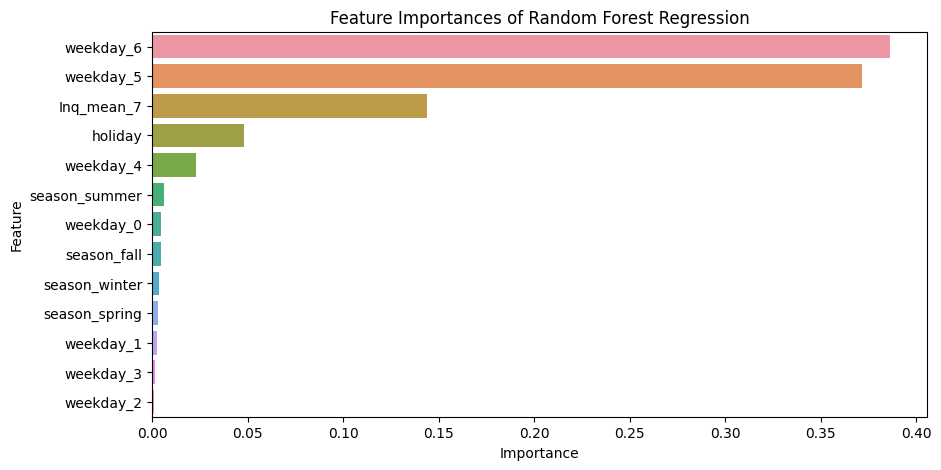

In [175]:
# Access the feature importances
importances = best_rfr_all.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()
